In [ ]:
!pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Importing all required packages
import numpy as np
import pandas as pd

from sklearn.metrics import silhouette_score

# Data viz lib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import xticks

In [ ]:
df = pd.read_csv('datasets/bankmarketing.csv')

In [ ]:
df = df.drop(['day_of_week','month', 'contact', 'y', 'cons.price.idx', 'emp.var.rate', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'poutcome'], axis=1)

In [ ]:
df.head()

age        job  marital    education  default housing loan  duration  \
0   56  housemaid  married     basic.4y       no      no   no       261   
1   57   services  married  high.school  unknown      no   no       149   
2   37   services  married  high.school       no     yes   no       226   
3   40     admin.  married     basic.6y       no      no   no       151   
4   56   services  married  high.school       no      no  yes       307   

   campaign  pdays  previous  
0         1    999         0  
1         1    999         0  
2         1    999         0  
3         1    999         0  
4         1    999         0

##DATASET:

*   age (numeric)
*   job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
*   marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
*   education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
*   default: has credit in default? (categorical: 'no','yes','unknown')
*   housing: has housing loan? (categorical: 'no','yes','unknown')
*   loan: has personal loan? (categorical: 'no','yes','unknown')




In [ ]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
housing      object
loan         object
duration      int64
campaign      int64
pdays         int64
previous      int64
dtype: object

In [ ]:
df_cat = df.loc[:, df.dtypes == object]

In [ ]:
df_cat.head()

job  marital    education  default housing loan
0  housemaid  married     basic.4y       no      no   no
1   services  married  high.school  unknown      no   no
2   services  married  high.school       no     yes   no
3     admin.  married     basic.6y       no      no   no
4   services  married  high.school       no      no  yes

In [ ]:
df_cat.describe()

job  marital          education default housing   loan
count    41188    41188              41188   41188   41188  41188
unique      12        4                  8       3       3      3
top     admin.  married  university.degree      no     yes     no
freq     10422    24928              12168   32588   21576  33950

In [ ]:
# Checking Null values
df_cat.isnull().sum()*100/df_cat.shape[0]
# There are no NULL values in the dataset, hence it is clean.

job          0.0
marital      0.0
education    0.0
default      0.0
housing      0.0
loan         0.0
dtype: float64

## LABEL-ENCODING

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_cat = df_cat.apply(le.fit_transform)
df_cat.head()

job  marital  education  default  housing  loan
0    3        1          0        0        0     0
1    7        1          3        1        0     0
2    7        1          3        0        2     0
3    0        1          1        0        0     0
4    7        1          3        0        0     2

## K-MODES Y ELBOW

In [ ]:
from kmodes.kmodes import KModes

In [ ]:
# Rango de valores k a probar
k_values = range(2, 7)
cost = []
sil = []

# Iteramos sobre cada valor de k
for k in k_values:
    # Instanciamos el algoritmo k-modes
    km = KModes(n_clusters=k, init='Cao', n_init=5, verbose=0)

    # Ajustamos el modelo con los datos
    clusters = km.fit_predict(df_cat)
    cost.append(km.cost_)

    # Calculamos el silhouette score para los clusters
    silhouette_avg = silhouette_score(df_cat, clusters, metric='hamming')
    sil.append(silhouette_avg)
    print("Para k =", k, "el silhouette score es", silhouette_avg)

Para k = 2 el silhouette score es 0.14011558684896624
Para k = 3 el silhouette score es 0.13870113379610938
Para k = 4 el silhouette score es 0.1370145050123975
Para k = 5 el silhouette score es 0.07356795415512016
Para k = 6 el silhouette score es 0.08151533026950969


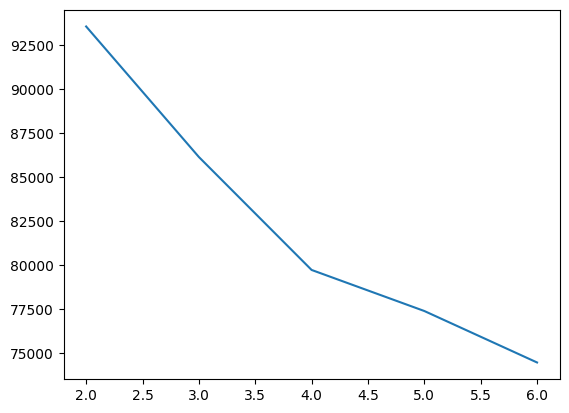

In [ ]:
y = np.array([i for i in k_values])
plt.plot(y, cost)
plt.show()

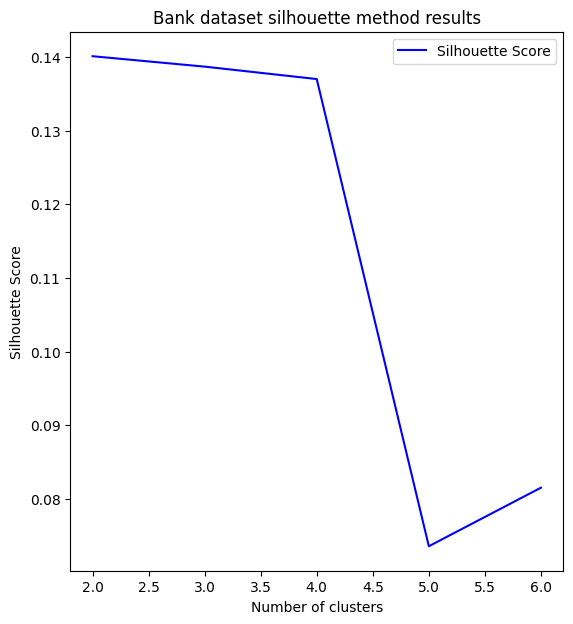

In [ ]:
fig = plt.figure(figsize=(14,7))
fig.add_subplot(122)
plt.title("Bank dataset silhouette method results")
plt.plot(k_values, sil,'b-',label='Silhouette Score')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

## MODELO

In [ ]:
#k=4
km_cao = KModes(n_clusters=4, init = "Cao", n_init = 5, verbose=1)
model = km_cao.fit_predict(df_cat)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3882, cost: 79724.0
Run 1, iteration: 2/100, moves: 147, cost: 79724.0


In [ ]:
clusterCentroidsDf = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroidsDf.columns = df_cat.columns

In [ ]:
clusterCentroidsDf

job  marital  education  default  housing  loan
0    0        1          6        0        2     0
1    1        2          3        0        0     0
2    1        1          2        1        0     0
3    9        1          5        0        0     2

## UNIR AMBOS DATASETS

In [ ]:
model = pd.DataFrame(model)
df_combined = pd.concat([df_cat, model], axis =1)
df_combined = df_combined.rename(columns = {0:"cluster"})
df_combined.head()

job  marital  education  default  housing  loan  cluster
0    3        1          0        0        0     0        0
1    7        1          3        1        0     0        2
2    7        1          3        0        2     0        0
3    0        1          1        0        0     0        0
4    7        1          3        0        0     2        3

In [ ]:
df_combined['cluster'].value_counts().sort_values(ascending=False)

0    23617
1     8626
2     6150
3     2795
Name: cluster, dtype: int64

In [ ]:
cluster_0 = df_combined[df_combined['cluster'] == 0]
cluster_1 = df_combined[df_combined['cluster'] == 1]
cluster_2 = df_combined[df_combined['cluster'] == 2]
cluster_3 = df_combined[df_combined['cluster'] == 3]

In [ ]:
cluster_0.describe()

job       marital     education       default       housing  \
count  23617.000000  23617.000000  23617.000000  23617.000000  23617.000000   
mean       3.350256      1.113139      4.308676      0.115383      1.521955   
std        3.580985      0.587229      2.097672      0.319623      0.840439   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      1.000000      3.000000      0.000000      2.000000   
50%        2.000000      1.000000      5.000000      0.000000      2.000000   
75%        7.000000      1.000000      6.000000      0.000000      2.000000   
max       11.000000      3.000000      7.000000      2.000000      2.000000   

               loan  cluster  
count  23617.000000  23617.0  
mean       0.274294      0.0  
std        0.672394      0.0  
min        0.000000      0.0  
25%        0.000000      0.0  
50%        0.000000      0.0  
75%        0.000000      0.0  
max        2.000000      0.0

In [ ]:
cluster_1.describe()

job      marital    education      default     housing  \
count  8626.000000  8626.000000  8626.000000  8626.000000  8626.00000   
mean      4.321934     1.532344     3.086715     0.089729     0.40946   
std       3.515547     0.709151     1.805022     0.286215     0.79402   
min       0.000000     0.000000     0.000000     0.000000     0.00000   
25%       1.000000     1.000000     2.000000     0.000000     0.00000   
50%       4.000000     2.000000     3.000000     0.000000     0.00000   
75%       7.000000     2.000000     3.000000     0.000000     0.00000   
max      11.000000     3.000000     7.000000     2.000000     2.00000   

              loan  cluster  
count  8626.000000   8626.0  
mean      0.212613      1.0  
std       0.599330      0.0  
min       0.000000      1.0  
25%       0.000000      1.0  
50%       0.000000      1.0  
75%       0.000000      1.0  
max       2.000000      1.0

In [ ]:
cluster_2.describe()

job      marital    education      default      housing  \
count  6150.000000  6150.000000  6150.000000  6150.000000  6150.000000   
mean      2.848455     0.985528     2.192846     0.802764     0.571545   
std       2.997879     0.330021     1.860796     0.397944     0.886466   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     1.000000     1.000000     1.000000     0.000000   
50%       1.000000     1.000000     2.000000     1.000000     0.000000   
75%       5.000000     1.000000     2.000000     1.000000     2.000000   
max      11.000000     3.000000     7.000000     1.000000     2.000000   

              loan  cluster  
count  6150.000000   6150.0  
mean      0.275610      2.0  
std       0.666783      0.0  
min       0.000000      2.0  
25%       0.000000      2.0  
50%       0.000000      2.0  
75%       0.000000      2.0  
max       2.000000      2.0

In [ ]:
cluster_3.describe()

job      marital    education     default      housing  \
count  2795.000000  2795.000000  2795.000000  2795.00000  2795.000000   
mean      6.971735     0.978891     4.461181     0.05975     0.411807   
std       3.102564     0.463312     1.605348     0.23857     0.782094   
min       0.000000     0.000000     0.000000     0.00000     0.000000   
25%       5.000000     1.000000     5.000000     0.00000     0.000000   
50%       9.000000     1.000000     5.000000     0.00000     0.000000   
75%       9.000000     1.000000     5.000000     0.00000     0.000000   
max      11.000000     3.000000     7.000000     2.00000     2.000000   

              loan  cluster  
count  2795.000000   2795.0  
mean      1.244723      3.0  
std       0.947553      0.0  
min       0.000000      3.0  
25%       0.000000      3.0  
50%       2.000000      3.0  
75%       2.000000      3.0  
max       2.000000      3.0

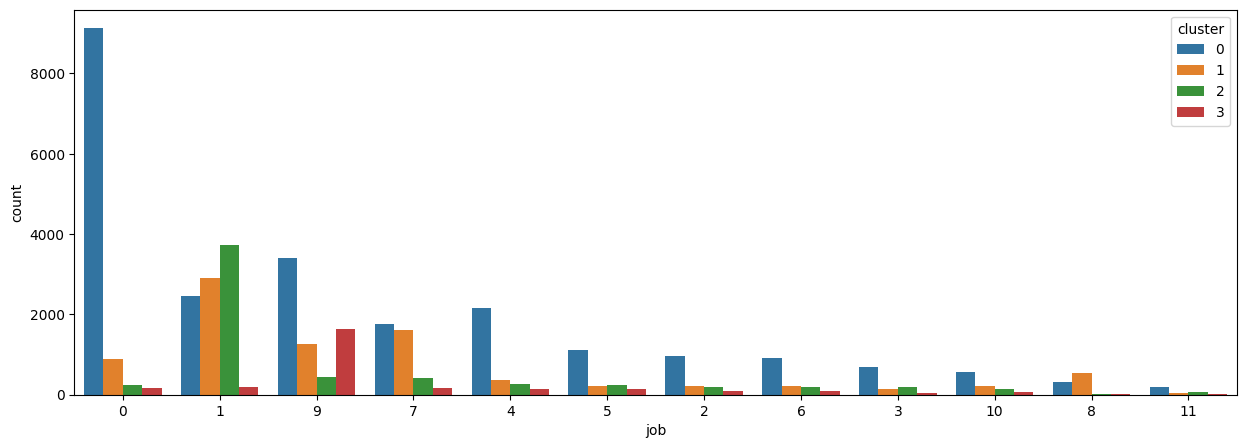

In [ ]:
plt.subplots(figsize = (15,5))
sns.countplot(x=df_combined['job'],order=df_combined['job'].value_counts().index,hue=df_combined['cluster'])
plt.show()

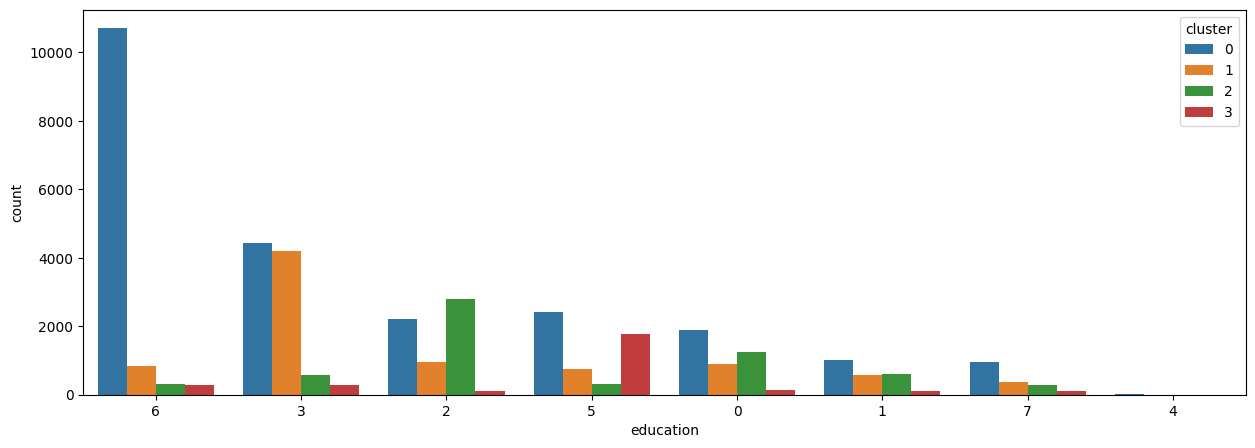

In [ ]:
plt.subplots(figsize = (15,5))
sns.countplot(x=df_combined['education'],order=df_combined['education'].value_counts().index,hue=df_combined['cluster'])
plt.show()

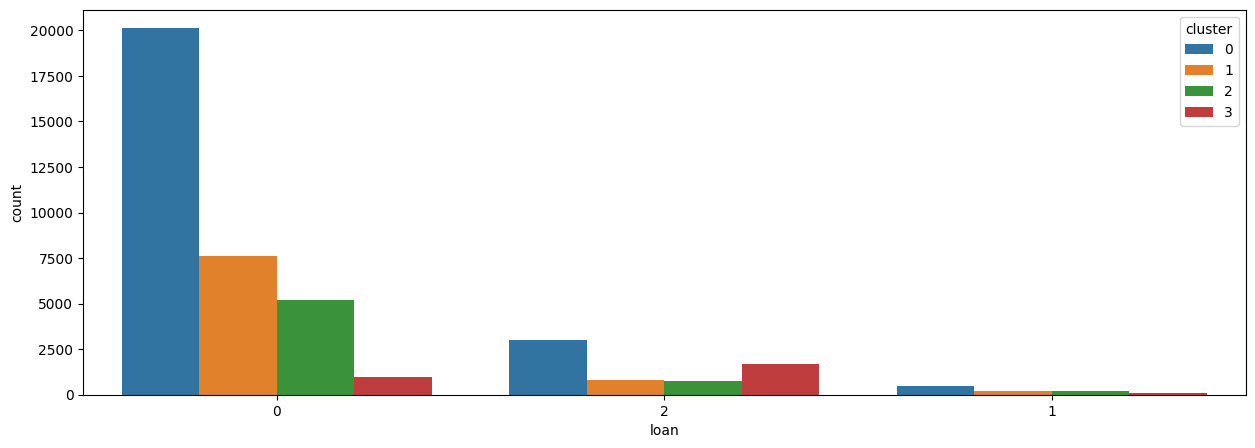

In [ ]:
plt.subplots(figsize = (15,5))
sns.countplot(x=df_combined['loan'],order=df_combined['loan'].value_counts().index,hue=df_combined['cluster'])
plt.show()

## Mejoremos el modelo


Nos quedamos con las variables que vemos que ofrecen diferencias para luego comparar con la edad y poner apoprtar explicabilidad.

In [ ]:
df2 = df.filter(['job', 'education','loan'], axis=1)

In [ ]:
df2.head()

job    education loan
0  housemaid     basic.4y   no
1   services  high.school   no
2   services  high.school   no
3     admin.     basic.6y   no
4   services  high.school  yes

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df2 = df2.apply(le.fit_transform)
df2.head()

job  education  loan
0    3          0     0
1    7          3     0
2    7          3     0
3    0          1     0
4    7          3     2

In [ ]:
from kmodes.kmodes import KModes

In [ ]:
# Rango de valores k a probar
k_values2 = range(2, 10)
cost2 = []
sil2 = []

# Iteramos sobre cada valor de k
for k in k_values2:
    # Instanciamos el algoritmo k-modes
    km2 = KModes(n_clusters=k, init='Cao', n_init=5, verbose=0)

    # Ajustamos el modelo con los datos
    clusters2 = km2.fit_predict(df2)
    cost2.append(km2.cost_)

    # Calculamos el silhouette score para los clusters
    silhouette_avg2 = silhouette_score(df2, clusters2, metric='hamming')
    sil2.append(silhouette_avg2)
    print("Para k =", k, "el silhouette score es", silhouette_avg2)

Para k = 2 el silhouette score es 0.20246656908348842
Para k = 3 el silhouette score es 0.25545322481173305
Para k = 4 el silhouette score es 0.2458063574543614
Para k = 5 el silhouette score es 0.2535038267095699
Para k = 6 el silhouette score es 0.23672904862861324
Para k = 7 el silhouette score es 0.23343479994330388
Para k = 8 el silhouette score es 0.19423162399154364
Para k = 9 el silhouette score es 0.10301079858103096


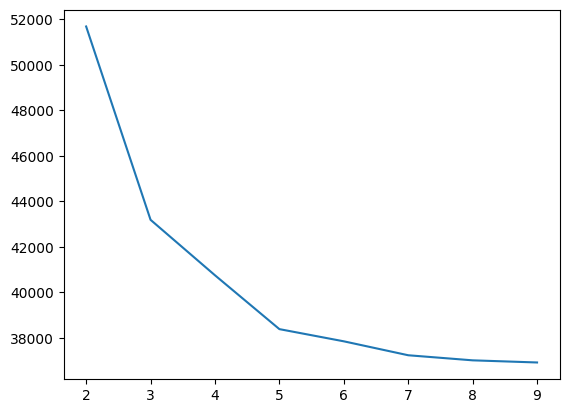

In [ ]:
y2 = np.array([i for i in k_values2])
plt.plot(y2, cost2)
plt.show()

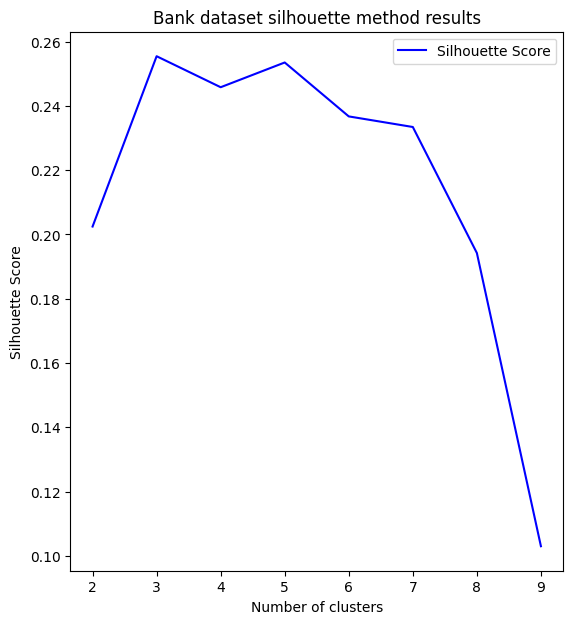

In [ ]:
fig = plt.figure(figsize=(14,7))
fig.add_subplot(122)
plt.title("Bank dataset silhouette method results")
plt.plot(k_values2, sil2,'b-',label='Silhouette Score')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

In [ ]:
#k=5
km_cao2 = KModes(n_clusters=5, init = "Cao", n_init = 5, verbose=1)
model2 = km_cao2.fit_predict(df2)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2824, cost: 38391.0
Run 1, iteration: 2/100, moves: 1258, cost: 38391.0


Vemos que claramente hay 5 clusters. El coste ha bajado de 17,000 a 4,800.

In [ ]:
model2 = pd.DataFrame(model2)
df_final = pd.concat([df2, model2], axis =1)
df_final = df_final.rename(columns = {0:"cluster"})
df_final.head()

job  education  loan  cluster
0    3          0     0        4
1    7          3     0        1
2    7          3     0        1
3    0          1     0        0
4    7          3     2        1

In [ ]:
df_final['cluster'].value_counts().sort_values(ascending=False)

0    17738
1    14468
2     5168
3     2047
4     1767
Name: cluster, dtype: int64

In [ ]:
cluster_0B = df_final[df_final['cluster'] == 0]
cluster_1B = df_final[df_final['cluster'] == 1]
cluster_2B = df_final[df_final['cluster'] == 2]
cluster_3B = df_final[df_final['cluster'] == 3]
cluster_4B = df_final[df_final['cluster'] == 4]

In [ ]:
cluster_0B.describe()

job     education          loan  cluster
count  17738.000000  17738.000000  17738.000000  17738.0
mean       2.447401      5.188465      0.341583      0.0
std        3.400130      1.542339      0.737427      0.0
min        0.000000      0.000000      0.000000      0.0
25%        0.000000      5.000000      0.000000      0.0
50%        0.000000      6.000000      0.000000      0.0
75%        4.000000      6.000000      0.000000      0.0
max       11.000000      7.000000      2.000000      0.0

In [ ]:
cluster_1B.describe()

job     education          loan  cluster
count  14468.000000  14468.000000  14468.000000  14468.0
mean       3.173486      2.260506      0.317805      1.0
std        3.079852      1.472335      0.714073      0.0
min        1.000000      0.000000      0.000000      1.0
25%        1.000000      1.000000      0.000000      1.0
50%        1.000000      2.000000      0.000000      1.0
75%        7.000000      3.000000      0.000000      1.0
max       11.000000      7.000000      2.000000      1.0

In [ ]:
cluster_2B.describe()

job    education         loan  cluster
count  5168.000000  5168.000000  5168.000000   5168.0
mean      8.317918     4.735681     0.310565      2.0
std       1.705684     1.145919     0.707797      0.0
min       2.000000     0.000000     0.000000      2.0
25%       9.000000     5.000000     0.000000      2.0
50%       9.000000     5.000000     0.000000      2.0
75%       9.000000     5.000000     0.000000      2.0
max      11.000000     7.000000     2.000000      2.0

In [ ]:
cluster_3B.describe()

job    education         loan  cluster
count  2047.000000  2047.000000  2047.000000   2047.0
mean      6.192477     2.127015     0.319980      3.0
std       2.208816     1.478252     0.715494      0.0
min       2.000000     0.000000     0.000000      3.0
25%       5.000000     2.000000     0.000000      3.0
50%       7.000000     2.000000     0.000000      3.0
75%       7.000000     2.000000     0.000000      3.0
max      11.000000     7.000000     2.000000      3.0

In [ ]:
cluster_4B.describe()

job    education         loan  cluster
count  1767.000000  1767.000000  1767.000000   1767.0
mean      4.764573     0.437465     0.322015      4.0
std       2.145614     1.611616     0.714584      0.0
min       2.000000     0.000000     0.000000      4.0
25%       3.000000     0.000000     0.000000      4.0
50%       5.000000     0.000000     0.000000      4.0
75%       5.000000     0.000000     0.000000      4.0
max      11.000000     7.000000     2.000000      4.0

Vemos que las mayores diferencias entre los clientes del banco son la educación y si tiene una hipoteca contratada. 

In [ ]:
df['cluster'] = df_final['cluster']

In [ ]:
import plotly.express as px
import plotly
fig = px.scatter_3d(df, x='job', y='education', z='loan', color='cluster',title="Bank Clustering with 3 variables")
fig.show()

In [ ]:
import plotly.express as px
import plotly
fig = px.scatter_3d(df, x='education', y='loan', z='age', color='cluster',title="Bank Customers")
fig.show()

In [ ]:
import plotly.express as px
import plotly
fig = px.scatter_3d(df, x='job', y='housing', z='age', color='cluster',title="Bank Customers")
fig.show()